# Learning Stable Control-oriented Deep Koopman Operators  


This tutorial demonstrates the use of [Deep Koopman Operators](https://www.nature.com/articles/s41467-018-07210-0) (DeepKO) with stability guarantees for system identificaiton of nonautonomous nonlinear dynamical systems in NeuroMANCER. 


## Koopman System Identification with Control Problem Setup

<img src="../figs/Koopman_model.png" width="500">  


System observables  $y_{k}$ and control inputs $u_k$ are encoded via encoder neural networks $f_y$ and $f_u$ to generate latent states $x_{k}$ (linear coordinates). This coordinate transformation now allos to apply linear Koopman operator $K$ to obtain latent states at the next time step $x_{k+1}$. After the rollout over given prediction horizon $N$ the generated latent trajectories $\{x_1, ..., x_N \}$ are proejcted back to the observable space via decoder neural network $f_y^{-1}$.
Now this Koopman encoder-decoder model can be trained as any other black-box nonlinear system identification problem with the loss $\mathcal{L}$ evaluated by comparing the  trajectory generated by the model with the training trajectory. 


### Koopman with Control References

[1] [H. Shi and M. Q. . -H. Meng, "Deep Koopman Operator With Control for Nonlinear Systems," in IEEE Robotics and Automation Letters, vol. 7, no. 3, pp. 7700-7707, July 2022, doi: 10.1109/LRA.2022.3184036.](https://ieeexplore.ieee.org/document/9799788)  
[2] [Eurika Kaiser and J Nathan Kutz and Steven L Brunton, Data-driven discovery of Koopman eigenfunctions for control, Mach. Learn.: Sci. Technol. 2021](https://iopscience.iop.org/article/10.1088/2632-2153/abf0f5)  
[3] [M. Korda and I. Mezić, "Optimal Construction of Koopman Eigenfunctions for Prediction and Control," in IEEE Transactions on Automatic Control, vol. 65, no. 12, pp. 5114-5129, Dec. 2020](https://ieeexplore.ieee.org/document/9022864)  
[4] [Yiqiang Han, Wenjian Hao, Umesh Vaidya, Deep Learning of Koopman Representation for Control, 2020
](https://arxiv.org/abs/2010.07546)  
[6] [Minghao Han, Jacob Euler-Rolle, Robert K. Katzschmann, DeSKO: Stability-Assured Robust Control with a Deep Stochastic Koopman Operator, ICLR 2022](https://openreview.net/forum?id=hniLRD_XCA)  
[6] https://github.com/HaojieSHI98/DeepKoopmanWithControl


### Generic Stable Layers References
[7]  [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021, pp. 3993-4000](https://ieeexplore.ieee.org/document/9482930)   
[8] [J. Drgoňa, A. Tuor, S. Vasisht and D. Vrabie, "Dissipative Deep Neural Dynamical Systems," in IEEE Open Journal of Control Systems, 2022](https://ieeexplore.ieee.org/abstract/document/9809789)  
[9] [Jiong Zhang, Qi Lei, Inderjit S. Dhillon, Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization, InternationalConferenceonMachine Learning, 2018](https://arxiv.org/abs/1803.09327)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import time as tim

from neuromancer.psl import plot
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from models import TwoTank

torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation
- IverSimple

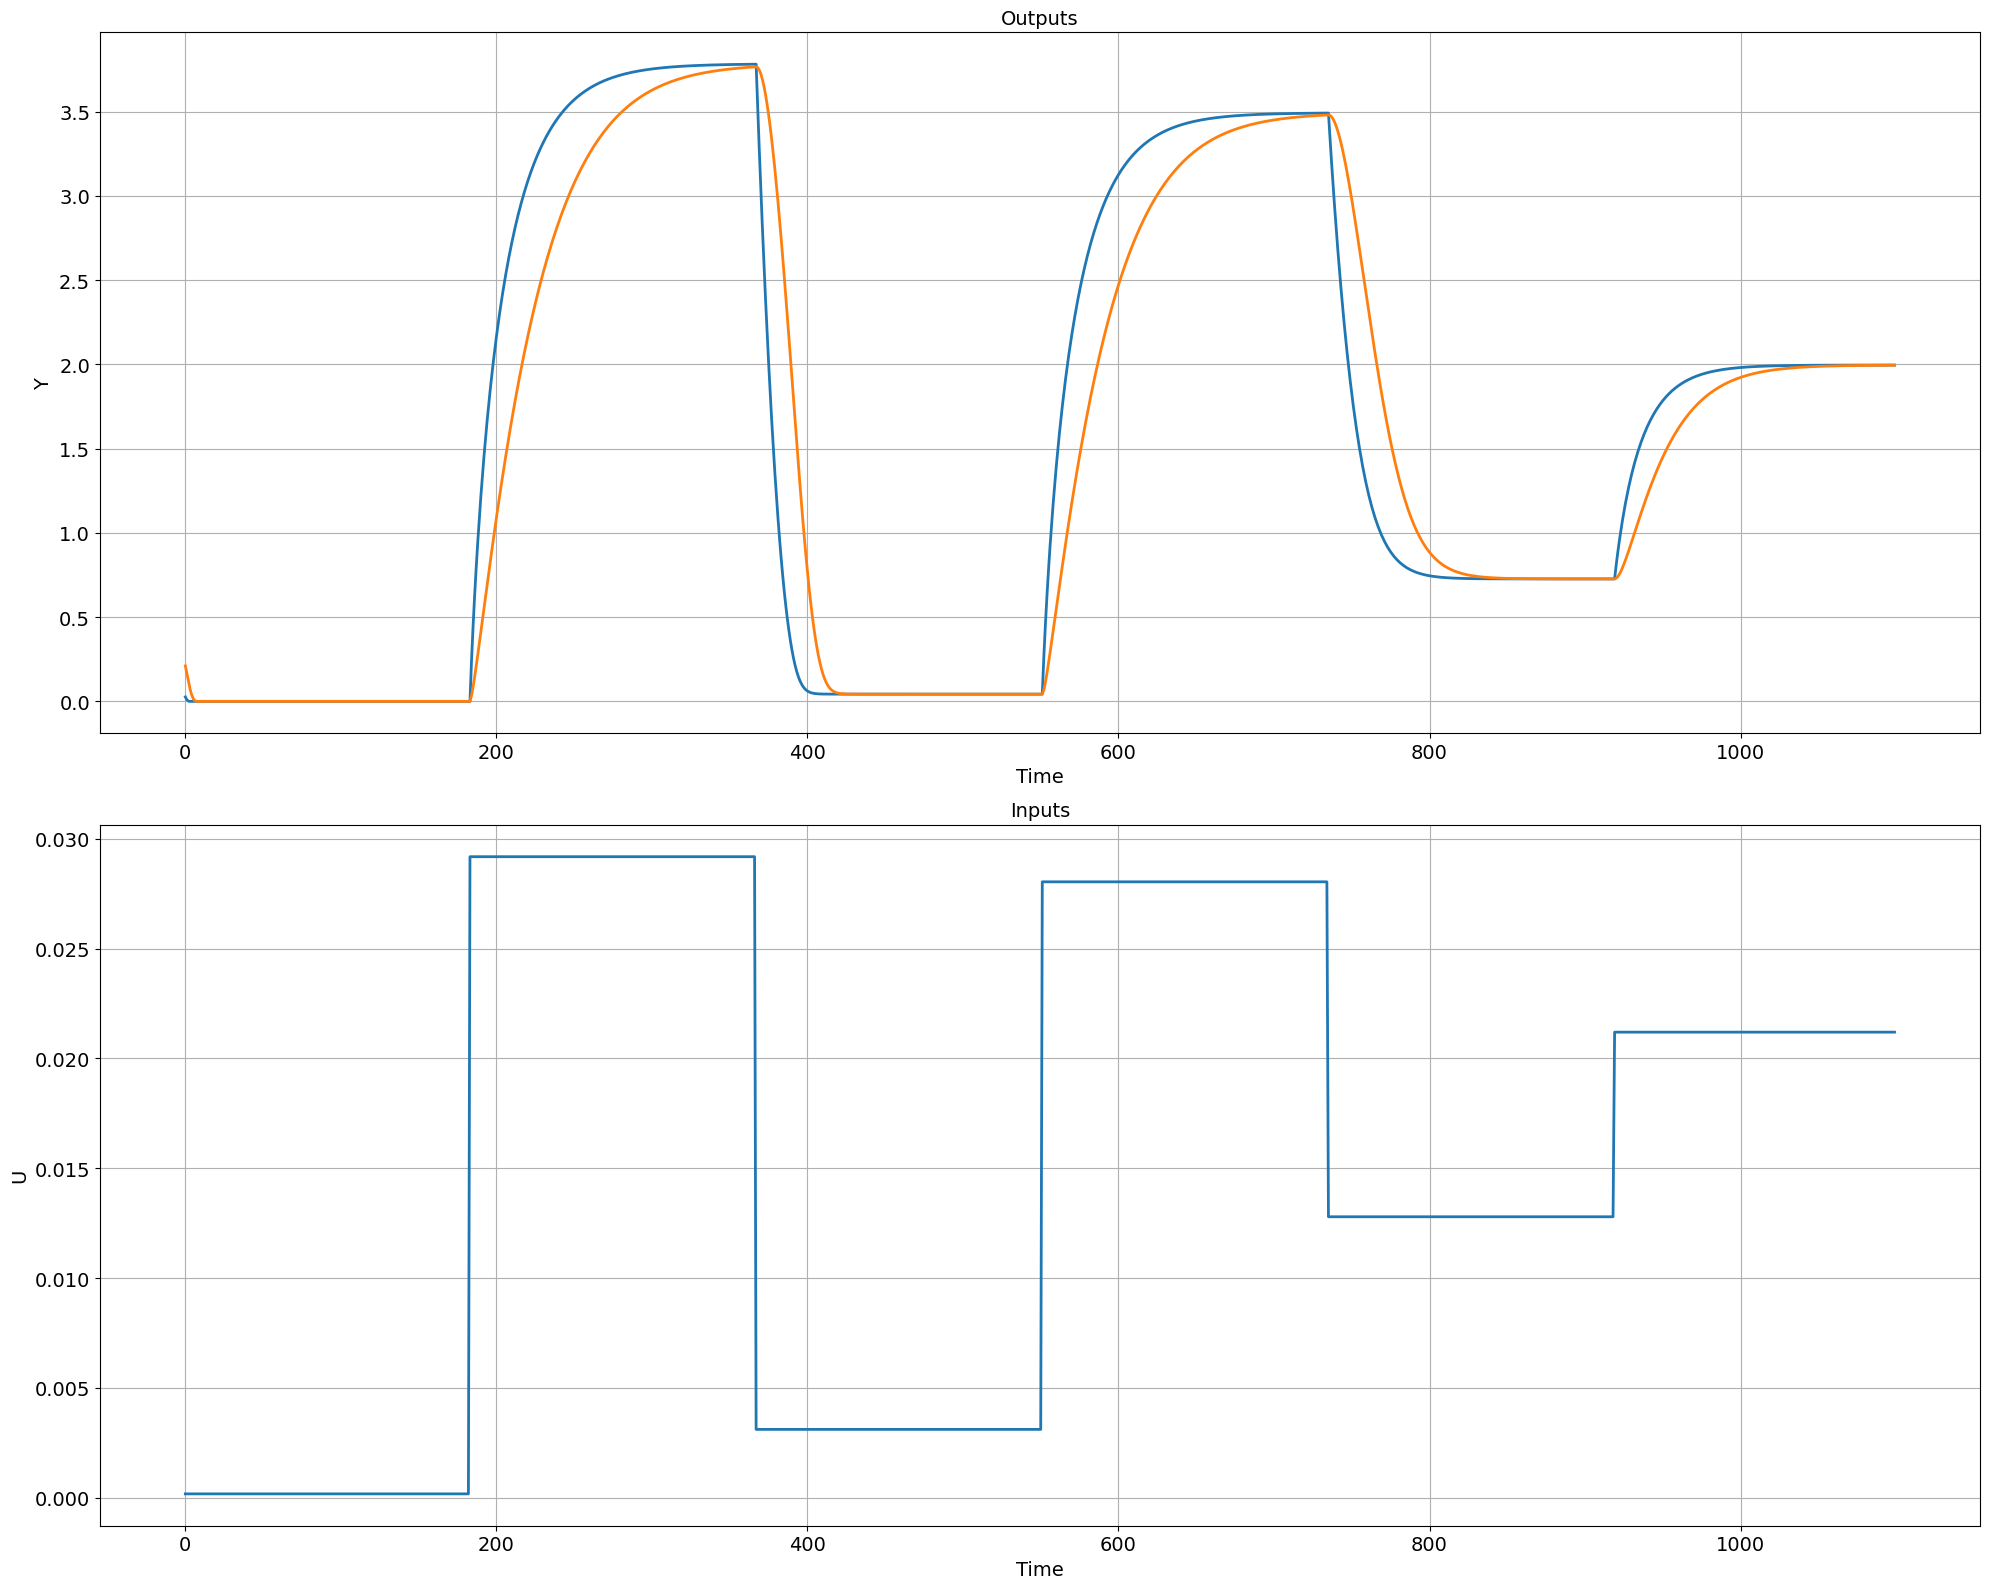

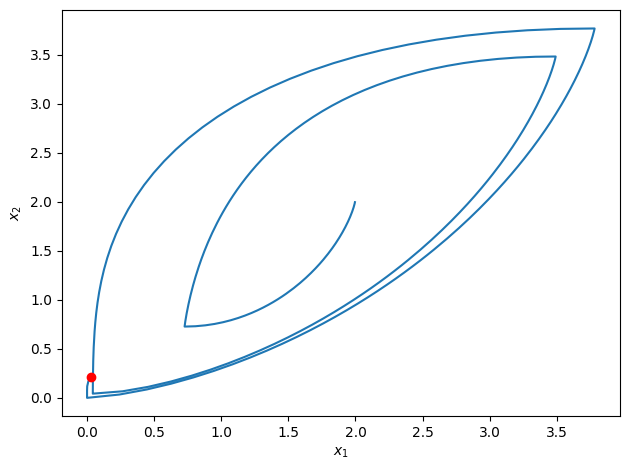

In [3]:
# %%  ground truth system
modelSystem = TwoTank()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1100, ts=ts)
plot.pltOL(Y=raw["Y"], U=raw["U"])
plot.pltPhase(X=raw["Y"])

In [4]:
def shift(data, delay):
    data["U"][:-delay] = data["U"][delay:]
    return


def add_noise(data, noise_level: float = 0.1, seed: int = 42):
    np.random.seed(seed)
    noise = np.random.normal(0, noise_level, data["X"].shape)
    data["X"] += noise
    data["X"][data["X"] < 0] = 0
    data["Y"] += noise
    data["Y"][data["Y"] < 0] = 0
    return


os.makedirs("data", exist_ok=True)
scipy.io.savemat("data/stats_of_system.mat", modelSystem.stats)

# Get and save data - (Already done)

In [5]:
# with open('test.pkl', 'wb') as fp:
#    pickle.dump(raw, fp)

In [6]:
train_sim, dev_sim, test_sim = [
    modelSystem.simulate(nsim=20000, ts=ts) for i in range(3)
]
shift(train_sim, 20)
shift(dev_sim, 20)
shift(test_sim, 20)

add_noise(train_sim, 0.1)
add_noise(dev_sim, 0.1)
add_noise(test_sim, 0.1)


with open("data/train_sim.pkl", "wb") as fp:
    pickle.dump(train_sim, fp)

with open("data/val_sim.pkl", "wb") as fp:
    pickle.dump(dev_sim, fp)

with open("data/test_sim.pkl", "wb") as fp:
    pickle.dump(test_sim, fp)

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.

In [7]:
def np_to_moving_window(array, window_size):
    # Calculate the number of windows
    num_windows = array.shape[0] - window_size + 1

    # Use stride_tricks to create a view of the array with the moving window
    shape = (num_windows, window_size, 2)
    strides = (array.strides[0], array.strides[0], array.strides[1])
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [8]:
# function for converting np.array data to lstm input as moving window sequences
def create_sequences(data, sequence_length):
    X = []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
    return np.array(X)

In [9]:
with open("data/train_sim.pkl", "rb") as fp:
    train_sim = pickle.load(fp)

with open("data/val_sim.pkl", "rb") as fp:
    val_sim = pickle.load(fp)

with open("data/test_sim.pkl", "rb") as fp:
    test_sim = pickle.load(fp)

In [10]:
def get_data(sys, nsim, nsteps, time, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """

    # train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    # shift(train_sim,20)
    # shift(dev_sim,20)
    # shift(test_sim,20)

    with open("data/train_sim.pkl", "rb") as fp:
        train_sim = pickle.load(fp)

    with open("data/val_sim.pkl", "rb") as fp:
        dev_sim = pickle.load(fp)

    with open("data/test_sim.pkl", "rb") as fp:
        test_sim = pickle.load(fp)

    nx = sys.nx
    nu = sys.nu
    nbatch = (nsim - time) // nsteps
    length = (nsim // nsteps) * nsteps
    print(length)
    mean_x = modelSystem.stats["Y"]["mean"]
    std_x = modelSystem.stats["Y"]["std"]
    mean_u = modelSystem.stats["U"]["mean"]
    std_u = modelSystem.stats["U"]["std"]

    def normalize(x, mean, std):
        return (x - mean) / std

    trainX_b = normalize(train_sim["Y"][:length], mean_x, std_x)
    trainX = trainX_b[time:].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU_b = normalize(train_sim["U"][:length], mean_u, std_u)
    trainU = trainU_b[time:].reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    trainUX_b = np.concatenate((trainX_b, trainU_b), axis=1)
    trainT = create_sequences(trainUX_b, time)
    trainT = trainT.reshape(nbatch, nsteps, time, nu + nx)
    trainT = torch.tensor(trainT, dtype=torch.float32)

    train_data = DictDataset(
        {
            "Y": trainX,
            "Y0": trainX[:, 0:1, :],
            "U": trainU,
            "timeYU0": trainT[:, 0:1, :, :].reshape(nbatch, time, nu + nx),
            "timeYU": trainT,
        },
        name="train",
    )
    train_loader = DataLoader(
        train_data,
        batch_size=bs,
        collate_fn=train_data.collate_fn,
        shuffle=True,
    )

    devX_b = normalize(dev_sim["Y"][:length], mean_x, std_x)
    devX = devX_b[time:].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU_b = normalize(dev_sim["U"][:length], mean_u, std_u)
    devU = devU_b[time:].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    devUX_b = np.concatenate((devX_b, devU_b), axis=1)
    devT = create_sequences(devUX_b, time)
    devT = devT.reshape(nbatch, nsteps, time, nu + nx)
    devT = torch.tensor(devT, dtype=torch.float32)

    dev_data = DictDataset(
        {
            "Y": devX,
            "Y0": devX[:, 0:1, :],
            "U": devU,
            "timeYU0": devT[:, 0:1, :, :].reshape(nbatch, time, nu + nx),
            "timeYU": devT,
        },
        name="dev",
    )
    dev_loader = DataLoader(
        dev_data, batch_size=bs, collate_fn=dev_data.collate_fn, shuffle=True
    )

    testX_b = normalize(test_sim["Y"][:length], mean_x, std_x)
    testX = testX_b[time:].reshape(nbatch, nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU_b = normalize(test_sim["U"][:length], mean_u, std_u)
    testU = testU_b[time:].reshape(nbatch, nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    testUX_b = np.concatenate((testX_b, testU_b), axis=1)
    testT = create_sequences(testUX_b, time)
    testT = testT.reshape(nbatch, nsteps, time, nu + nx)
    testT = torch.tensor(testT, dtype=torch.float32)

    test_data = {
        "Y": testX,
        "Y0": testX[:, 0:1, :],
        "U": testU,
        "timeYU0": testT[:, 0:1, :, :].reshape(nbatch, time, nu + nx),
        "timeYU": testT,
    }

    return train_loader, dev_loader, test_data

In [11]:
nsim = 20000  # number of simulation steps in the dataset
nsteps = 80  # number of prediction horizon steps in the loss function
bs = 100  # minibatching batch size
time = 80  # number of lookback window as input to lstm
train_loader, dev_loader, test_data = get_data(
    modelSystem, nsim, nsteps, time, bs
)

20000


In [12]:
scipy.io.savemat("data/train_sim.mat", train_sim)
scipy.io.savemat("data/val_sim.mat", val_sim)
scipy.io.savemat("data/test_sim.mat", test_sim)

In [13]:
max_length = float("-inf")
min_length = float("inf")

for batch in train_loader:
    # Assuming each batch contains input tensors
    # You can modify this based on your data structure

    for key, tensor in batch.items():
        # Get the length of the tensor
        try:
            length = tensor.shape[
                0
            ]  # Assuming tensor is of shape (length, ...)

            # Update max_length and min_length
            max_length = max(max_length, length)
            min_length = min(min_length, length)
        except:
            pass

print("Longest tensor length:", max_length)
print("Shortest tensor length:", min_length)

Longest tensor length: 100
Shortest tensor length: 49


In [14]:
next(iter(train_loader))["timeYU"].shape

torch.Size([100, 80, 80, 3])

## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

<img src="../figs/Koopman_model.png" width="500">  


Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [15]:
# model parameters
nx_koopman = 40
n_hidden = 60
n_layers = 2
lstm_features = 8

**LSTM + Encoder and Decoder networks** 

In [16]:
f_yu = blocks.LSTMBlock(ny + nu, lstm_features)
# f_yu = blocks.MLP(ny+nu, nx_koopman, bias=True,
# linear_map=torch.nn.Linear,
# nonlin=torch.nn.ELU,
# hsizes=n_layers*[n_hidden])
# self, input_dim, hidden_dim, num_layers=1, bidirectional=False, dropout=0.0):


def f_yuT(data):
    s = data.shape
    res = f_yu(data.reshape(s[0] * nsteps, time, ny + nu))
    return res.reshape(s[0], nsteps, lstm_features)


extract_time_features = Node(
    f_yuT, ["timeYU"], ["time_enc"], name="extract_time_features"
)

extract_time_features_0 = Node(
    f_yu, ["timeYU0"], ["time_enc0"], name="extract_time_features_0"
)

In [17]:
def stack(a, b):
    return torch.cat((a, b), dim=-1)

In [18]:
next(iter(train_loader))["Y0"].shape

torch.Size([100, 1, 2])

In [19]:
# next(iter(train_loader))['timeYU'].reshape(100*20, 80, 3).shape

In [20]:
# extract_time_features({'timeYU': next(iter(train_loader))['timeYU'],})['time_enc'].shape

In [21]:
next(iter(train_loader))["timeYU0"].shape

torch.Size([100, 80, 3])

In [22]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny + lstm_features,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
# initial condition encoder
encode_Y0 = Node(f_y, ["Y0_te"], ["x"], name="encoder_Y0")
# observed trajectory encoder
encode_Y = Node(f_y, ["Y_te"], ["x_latent"], name="encoder_Y")

stack_Y0 = Node(stack, ["Y0", "time_enc0"], ["Y0_te"], name="stack_Y0")
stack_Y = Node(stack, ["Y", "time_enc"], ["Y_te"], name="stack_Y")

In [23]:
# matrice B
K_B = torch.nn.Linear(nu, nx_koopman, bias=False)
encode_U = Node(K_B, ["U"], ["u_real"], name="encoder_U")

In [24]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(
    nx_koopman,
    ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
# predicted trajectory decoder
decode_y = Node(f_y_inv, ["x"], ["yhat"], name="decoder_y")

**Standard Koopman Operator** without stability guarantees is parametrized by linear layer of the latent size. 

**Stable Koopman Operator:**  For provably stable Koopman operator we can choose a range of linear algebra factorization that allow to constrain the eigenvalues of the resulting linear operator. 
In this example we use the following [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization of the operator given as:
$$K = U \Sigma V$$ 
$$\Sigma =  \text{diag}(\lambda_{\text{max}} - (\lambda_{\text{max}} - \lambda_{\text{min}}) \cdot \sigma(\Lambda)) $$
where $\sigma$ is logistic sigmoid activation function, $\cdot$ is a dot product, $\Lambda$ is a vector of eigenvalues of the linear operator, while $\lambda_{\text{max}}$ and $\lambda_{\text{min}}$ are constraints on maximum and minimum value of SVD factorized linear operator.

<img src="../figs/SVD_layer.png" width="300">  

In order for the SVD factorization to hold the left and right matrices $U$ and $V$, respectively, needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix).
This can be achieved either via [Householder reflectors](https://arxiv.org/abs/1803.09327), or via penalties in the loss function given as:  
$$\ell_{U} = || I - UU^T||_2 + || I - U^TU||_2  $$
$$\ell_{V} = || I - VV^T||_2 + || I - V^TV||_2  $$
$$\ell_{\text{stable}} = \ell_{U} + \ell_{V} $$

For more details on the SVD and other linear algebra factorizations of trainable linear layers see the references [[7]](https://ieeexplore.ieee.org/document/9482930) and [[8]](https://ieeexplore.ieee.org/abstract/document/9809789), with Pytorch implementations in the [slim submodule](https://github.com/pnnl/neuromancer/tree/master/src/neuromancer/slim) of the Neuromancer library. 

In [25]:
# instantiate Koopman operator matrix
stable = True  # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(
        nx_koopman, nx_koopman, sigma_min=0.01, sigma_max=1.0, bias=False
    )
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.0 * (K_reg_error == 0.0)
    K_reg_loss.name = "SVD_loss"
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [26]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K (x_k + u_k)
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [27]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ["x", "u_real"], ["x"], name="K")

# latent Koopmann rollout
dynamics_model = System([Koopman], name="Koopman", nsteps=nsteps)

In [28]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [
    extract_time_features,
    extract_time_features_0,
    stack_Y0,
    stack_Y,
    encode_Y0,
    encode_Y,
    encode_U,
    dynamics_model,
    decode_y,
]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [29]:
# variables
Y = variable("Y")  # observed
yhat = variable("yhat")  # predicted output
x_latent = variable(
    "x_latent"
)  # encoded output trajectory in the latent space
# u_latent = variable('u_latent')  # encoded input trajectory in the latent space
u_real = variable("u_real")  # real input trajectory
x = variable("x")  # Koopman latent space trajectory

# xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10.0 * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.0 * (yhat[:, 1, :] == Y[:, 1, :]) ^ 2
onestep_loss.name = "onestep_loss"

# latent trajectory tracking loss
x_loss = 1.0 * (x[:, 1:-1, :] == x_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [30]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [32]:
#problem.load_state_dict(torch.load("../models/LSTM_8.pth"), strict=False)

In [33]:
# plot computational graph
# problem.show()
# problem(next(iter(train_loader)))

In [34]:
print(problem.input_keys)
print(problem.output_keys)

['u_real', 'yhat', 'Y0_te', 'time_enc', 'x_latent', 'timeYU', 'Y', 'U', 'x', 'Y_te', 'Y0', 'time_enc0', 'timeYU0']
['u_real', 'yhat', 'penalty_loss', 'C_values', 'C_ineq_values', 'Y0_te', 'x_latent', 'objective_loss', 'x', 'C_eq_violations', 'loss', 'C_ineq_violations', 'Y_te', 'time_enc', 'time_enc0', 'C_violations', 'C_eq_values']


## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [35]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=200,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [36]:
# %% train
start = tim.time()
best_model = trainer.train()
problem.load_state_dict(best_model)
end = tim.time()

epoch: 0  train_loss: 21.69702911376953
epoch: 1  train_loss: 16.74481773376465
epoch: 2  train_loss: 11.68310546875
epoch: 3  train_loss: 8.733253479003906
epoch: 4  train_loss: 7.028709411621094
epoch: 5  train_loss: 7.880845546722412
epoch: 6  train_loss: 8.583484649658203
epoch: 7  train_loss: 7.140735149383545
epoch: 8  train_loss: 6.978818416595459
epoch: 9  train_loss: 6.970052242279053
epoch: 10  train_loss: 6.698679447174072
epoch: 11  train_loss: 7.271108627319336
epoch: 12  train_loss: 6.85174036026001
epoch: 13  train_loss: 6.554402828216553
epoch: 14  train_loss: 6.780820369720459
epoch: 15  train_loss: 6.425891399383545
epoch: 16  train_loss: 6.410826206207275
epoch: 17  train_loss: 6.466650485992432
epoch: 18  train_loss: 6.081700801849365
epoch: 19  train_loss: 6.129664897918701
epoch: 20  train_loss: 6.643886566162109
epoch: 21  train_loss: 5.985439300537109
epoch: 22  train_loss: 6.176746845245361
epoch: 23  train_loss: 6.6569671630859375
epoch: 24  train_loss: 5.9461

In [ ]:
# elapsed time
print("Elapsed time training: ", end - start)

Elapsed time training:  476.685017824173


In [ ]:
torch.save(best_model, "../models/LSTM_" + str(lstm_features) + ".pth")

## System Identification results

In [ ]:
problem.nodes

ModuleList(
  (0): extract_time_features(timeYU) -> time_enc
  (1): extract_time_features_0(timeYU0) -> time_enc0
  (2): stack_Y0(Y0, time_enc0) -> Y0_te
  (3): stack_Y(Y, time_enc) -> Y_te
  (4): encoder_Y0(Y0_te) -> x
  (5): encoder_Y(Y_te) -> x_latent
  (6): encoder_U(U) -> u_real
  (7): System(
    (nodes): ModuleList(
      (0): K(x, u_real) -> x
    )
  )
  (8): decoder_y(x) -> yhat
)

In [ ]:
test_data["Y"].shape

torch.Size([249, 80, 2])

In [ ]:
# update the rollout length based on the test data
problem.nodes[7].nsteps = test_data["Y"].shape[1]

In [ ]:
# Test set results
start = tim.time()
test_outputs = problem.step(test_data)
end = tim.time()
print("Elapsed time testing: ", end - start)

pred_traj = test_outputs["yhat"][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data["Y"][:, 1:, :].detach().numpy().reshape(-1, nx).T
input_traj = test_data["U"].detach().numpy().reshape(-1, nu).T

Elapsed time testing:  0.2675330638885498


In [ ]:
np.mean((pred_traj - true_traj) ** 2)

0.0042512952

In [ ]:
true_traj.shape

(2, 19671)

In [ ]:
pred_traj.shape

(2, 19671)

In [ ]:
mean_x = modelSystem.stats["Y"]["mean"]
std_x = modelSystem.stats["Y"]["std"]
mean_u = modelSystem.stats["U"]["mean"]
std_u = modelSystem.stats["U"]["std"]


def normalize(x, mean, std):
    return (x - mean) / std


def denormalize(x, mean, std):
    return x * std + mean


pred = {
    "h1": denormalize(pred_traj.T, mean_x, std_x)[:, 0],
    "h2": denormalize(pred_traj.T, mean_x, std_x)[:, 1],
}
scipy.io.savemat("data/pred_sim.mat", pred)
true = {
    "h1": denormalize(true_traj.T, mean_x, std_x)[:, 0],
    "h2": denormalize(true_traj.T, mean_x, std_x)[:, 1],
}
scipy.io.savemat("data/true_sim.mat", true)

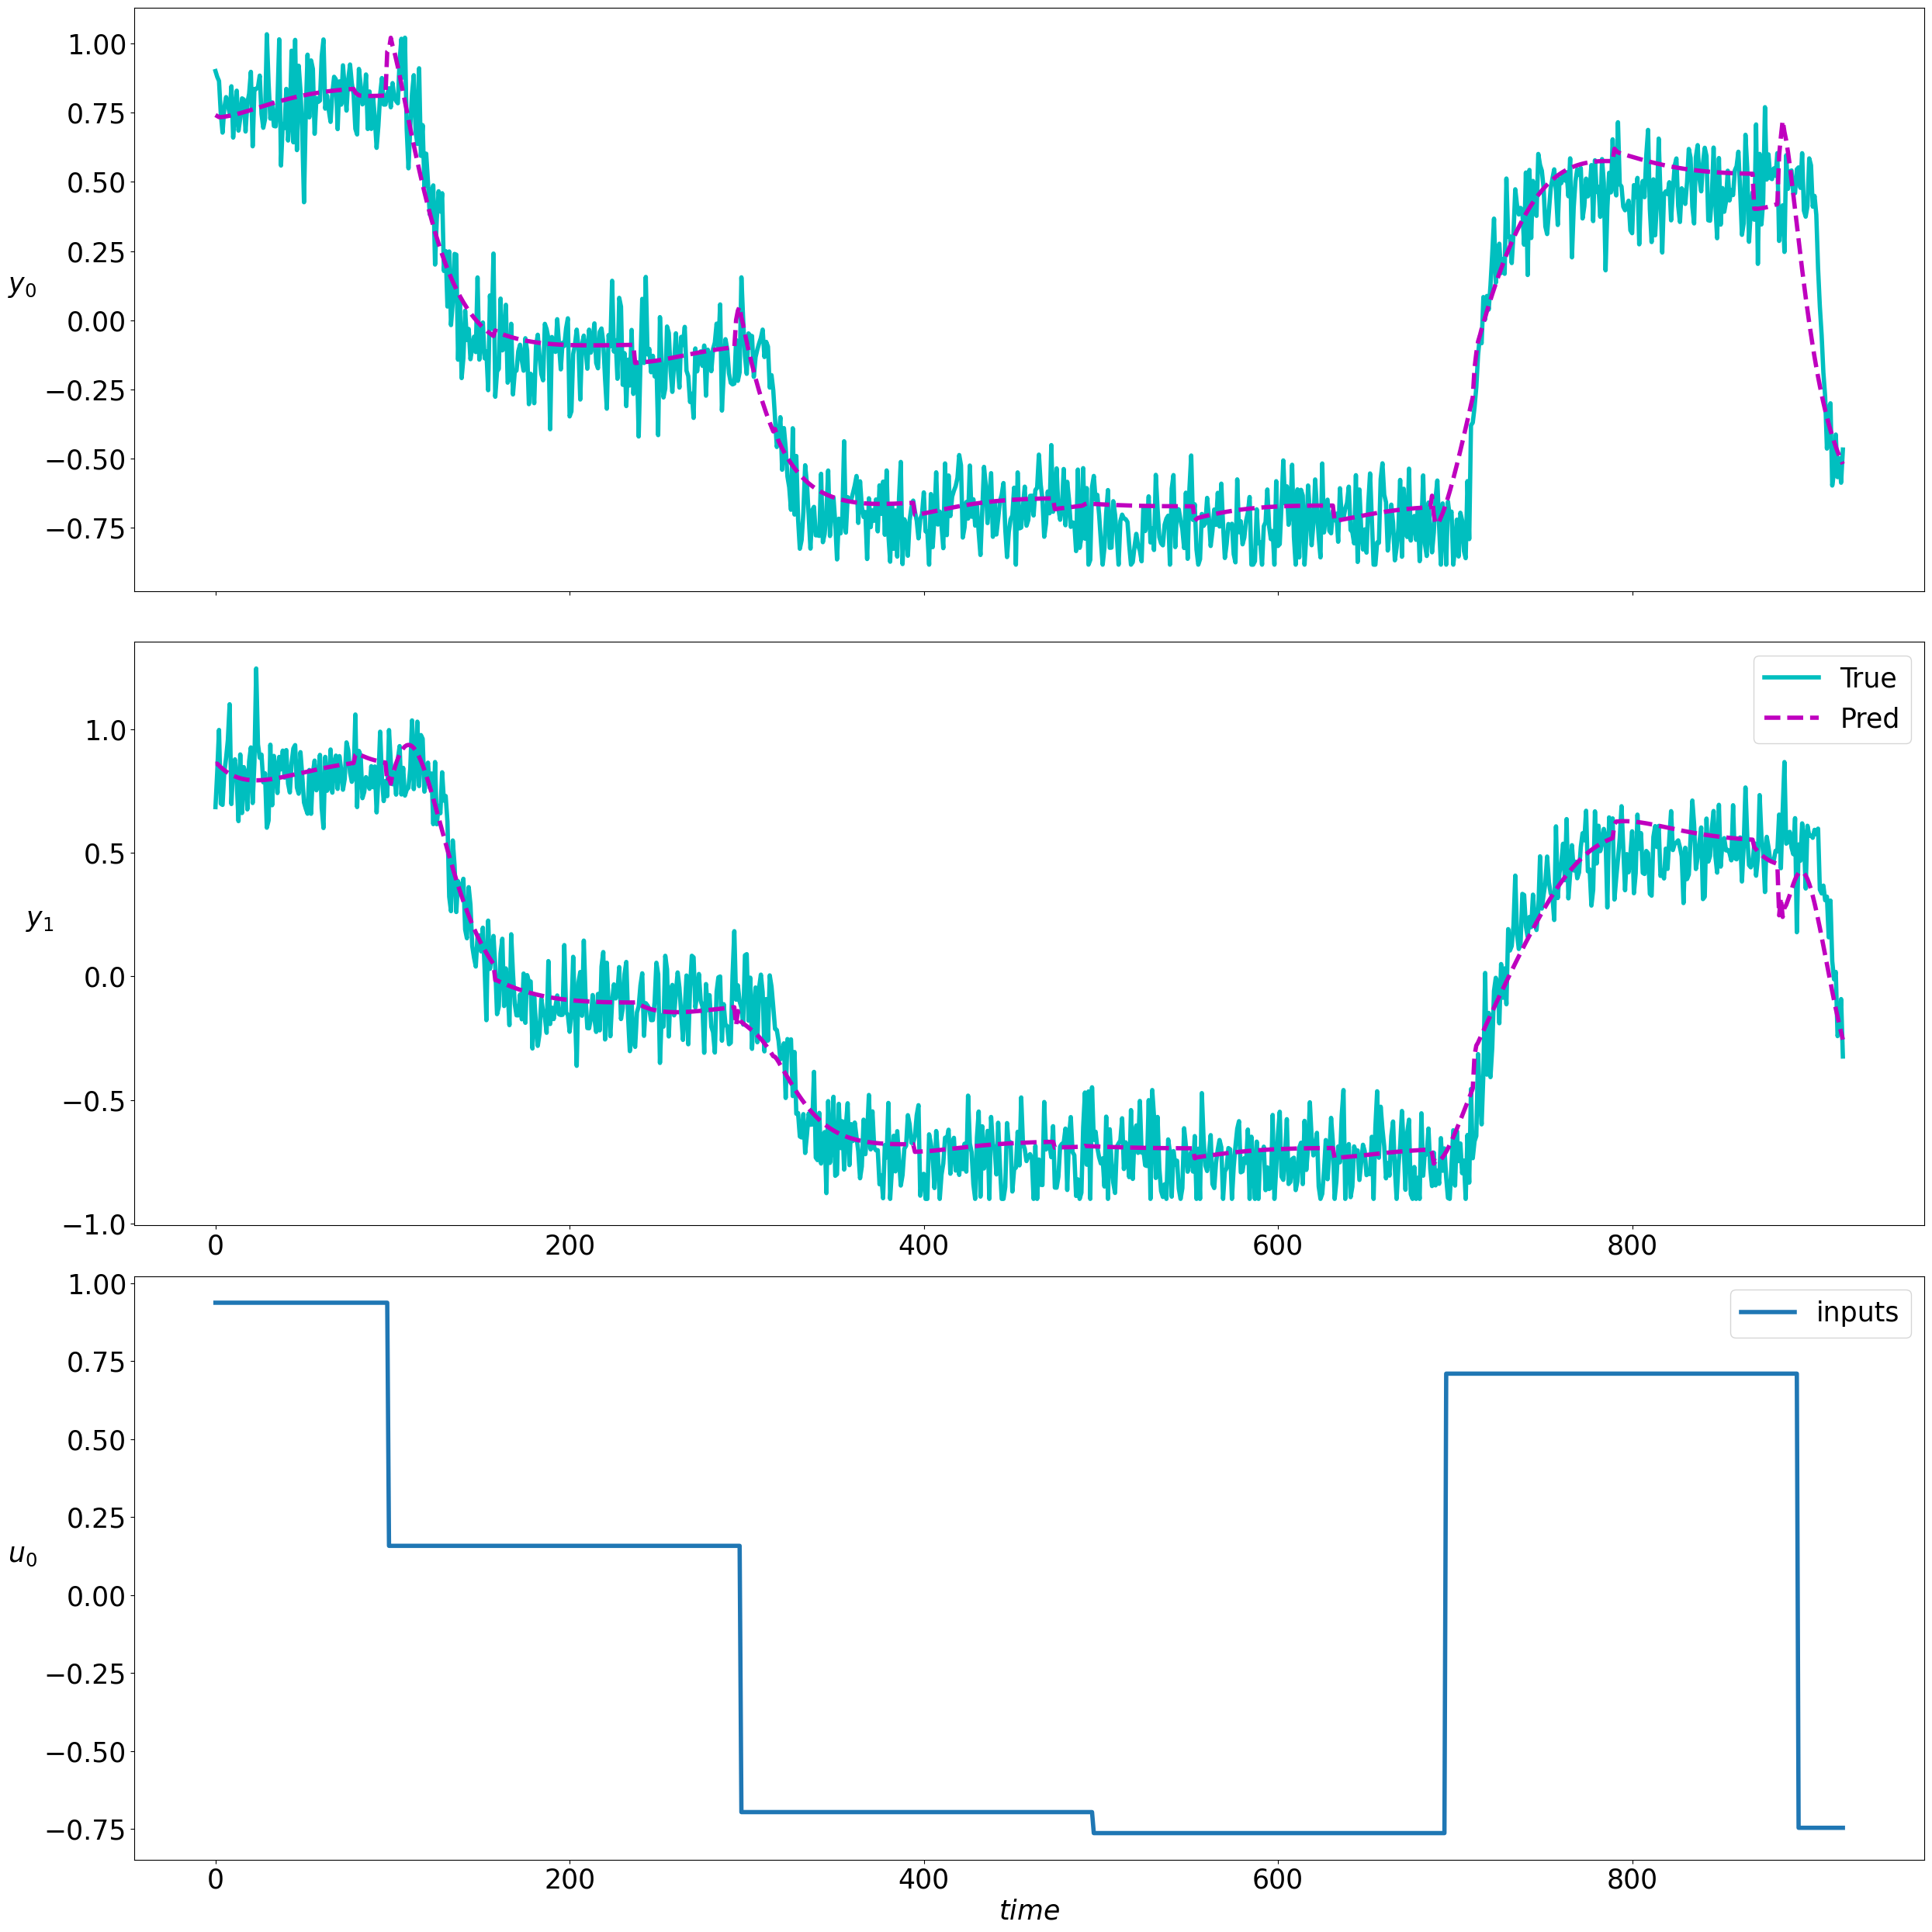

In [51]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))
part = 920


x_labels = [f"$y_{k}$" for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:part], "c", linewidth=4.0, label="True")
    axe.plot(t2[:part], "m--", linewidth=4.0, label="Pred")
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f"$u_{k}$" for k in range(len(input_traj))]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[row + nx]
    axe.plot(u[:part], linewidth=4.0, label="inputs")
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel("$time$", fontsize=figsize)
plt.tight_layout()

In [53]:
# save A and B matrices, where A = K.effective_W() and B = K_B.weight
A = K.effective_W().detach().numpy()
B = K_B.weight.detach().numpy()

np.save("../results/A_DeReK_noise.npy", A)
np.save("../results/B_DeReK_noise.npy", B)

In [ ]:
B

array([[ 0.44973925],
       [-0.3444679 ],
       [ 0.15635996],
       [ 0.94856334],
       [-0.423354  ],
       [ 0.44195104],
       [ 0.78990215],
       [-0.11196893],
       [ 0.8043624 ],
       [-0.30609998],
       [-0.19042452],
       [ 0.27173546],
       [-0.15513912],
       [-0.29542193],
       [-0.16737138],
       [ 0.16059211],
       [-0.51645565],
       [-0.73568034],
       [-0.75827235],
       [ 0.9706415 ],
       [ 0.03091915],
       [ 0.45654136],
       [-0.91225976],
       [-0.15925594],
       [-0.7500659 ],
       [-0.0449376 ],
       [ 0.88307005],
       [ 0.6796465 ],
       [-0.33637044],
       [-0.5026437 ],
       [-0.73937064],
       [-0.4578469 ],
       [ 0.29214785],
       [-0.5793597 ],
       [ 0.5433158 ],
       [-0.32241377],
       [ 0.87408495],
       [-0.21994412],
       [-0.16359156],
       [ 0.5853769 ]], dtype=float32)

In [ ]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

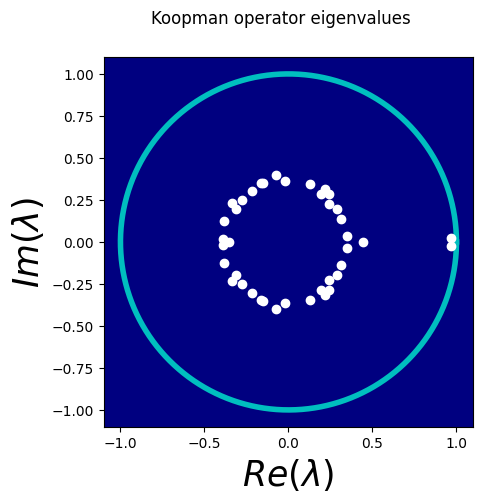

In [ ]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, "c", linewidth=4)
ax1.plot(eReal, eImag, "wo")
ax1.set_aspect("equal", "box")
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=figsize)
ax1.set_ylabel("$Im(\lambda)$", fontsize=figsize)
fig1.suptitle("Koopman operator eigenvalues")

In [ ]:
# compute Koopman state eigenvectors
y_min = 1.1 * test_data["Y"].min()
y_max = 1.1 * test_data["Y"].max()
y1 = torch.linspace(y_min, y_max, 1000)
y2 = torch.linspace(y_min, y_max, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = f_y(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:, :, 0]
phi_2 = phi.detach().numpy()[:, :, 1]
phi_3 = phi.detach().numpy()[:, :, 2]
phi_4 = phi.detach().numpy()[:, :, 3]
phi_5 = phi.detach().numpy()[:, :, 4]
phi_6 = phi.detach().numpy()[:, :, 6]

/Users/patrik/miniconda3/envs/neuromancer/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000000x2 and 10x60)

Text(0.5, 0.98, 'first six eigenfunctions')

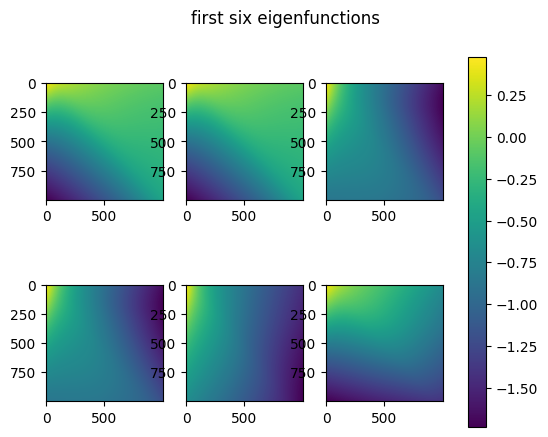

In [ ]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0, 0].imshow(phi_1)
im2 = axs[0, 1].imshow(phi_2)
im3 = axs[0, 2].imshow(phi_3)
im4 = axs[1, 0].imshow(phi_4)
im5 = axs[1, 1].imshow(phi_5)
im6 = axs[1, 2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle("first six eigenfunctions")